# **Fraud Detection on Credit Card Data**

*by Milara*

*September 2021*

**Introduction**:
- Machine Learning models are very useful for businesses in many industries. Nevertheless, to make a model be valuable for a company it must be presentend in terms that anyone in the company can easly understand. Rather than presenting a model in terms of a metric (Accuracy, F1, ROC-AUC) it is better to present it in terms of **monetary costs and/or benefits**. Unfortunately, many books focus only on the model metrics and not in the business metrics, however there a few books and sites providing relevant model-business techniques. This kernel shows an approach of how to deal with this problem.
- Furthermore, in real world scenarios a vast mayority of problems have to deal with **imbalanced datasets** as well. An imbalanced datset is when the amount of instances of the target variable, in this case the frauds, has higher number of the negative than the positive class. Many of the examples in the books are focused on how to train a model with balanced datasets and only mention some ideas to deal with imbalanced datasets, thus it is necessary to dig more to find how to deal with this problem. This kernel show some of the techiques to tackle this kind of issues.
- Link to the dataset used: https://www.kaggle.com/mlg-ulb/creditcardfraud
- This notebook is based on the notebook of Robin Teuwens with additions such as feature selection, hyperparameters tunning, learning and scalability curves and Cost/Profit curves[1].

**Objectives**:
  + To find the model that generates the **lowest cost to detect frauds**
  + To show how to **deal with imbalanced datasets**

**Content:**
- [Problem Understanding](#Problem-Understanding)
- [Data Understanding](#Data-Understanding)
	- Uni-variate analysis
	- Data Imbalanced
- [Data Preparation](#Data-Preparation)
	- Scaling data
	- Data Split
- [Cost Approach](#Cost-Approach)
	- Problem Assumptions
	- Marginal Cost
	- Cost of doing nothing
	- Cost of checking all transactions
- [Modeling](#Modeling)
	- Baseline model
	- Logistic Regression 
	- XGBoost 
- [Dealing with Imbalanced Datasets](#Dealing-with-Imbalanced-Datasets)
	- Resampling data
	- Testing SMOTE on models
- [Improving the Model](#Improving-the-Model)
	- Feature Selection
	- Hyperparameter tunning
- [Understanding the Performance of the Models](#Understanding-the-Performance-of-the-Models)
	- Fitting Curves
	- Learning and Scalability Curves
	- Missclassification cost per threshold
	- Cost/Profit Curves
    - Cost curves for all models
- [Feature Importance](#Feature-Importance)
- [Conclusion](#Conclusion.)
- [To Try](#To-Try)
- [References](#References.)


## **Problem Understanding**

- The data was obtained from Kaggle "Credit Card Fraud Detection" and provided by Machine Learning Group ULB. The data contains anonymized credit card transactions labaled as fradulent or genuine. The transactions were made by credit cards in September 2013 by European cardholders. **The data was retrieved from two day transactions, where only 492 were fraud out of 284,807.**
- The goal is to generate a model based on supervised learning that can **classify correctly the non-fraud an fraud transactions**.
- Depending on the problem the model has to be generated with the goal to minimize one or both errors. This problem considers both errors (to identify a non-fraud when it is and to identify a fraud when it is not). 
    - What will happen if the company does not identify frauds? they will have to reimburse the money and will lose reputation. 
    - What will happen if the company identify frauds when they are not? they will not have to reimburse the money, but for sure it will be a problem for their clients if they block their credit cards. 
    - This kernel will not consider the reputational costs, or if the company lose customers  due to model malfunction. 
- For the sake of simplicity two models will be used to make this task. **The models are Logistic Regression and XGBoost**. The first model is selected because it is simple to train and to tune. On the other hand, the second model is selected because it is known that can provide pretty good results but it is complex, it requires more resources to train, more hyperparameter fine-tunning and it is not easy interpretable. 
    

## **Data Understanding**

In [1]:
import pandas as pd

# read in data
df = pd.read_csv("C:/Users/Milara/Desktop/Practice_Jupyter/creditcard.csv") 
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

- The dataset has 30 explanatory variables and 1 target variable (Class)
- Two variables have an understandable name, Time and Amount.
- The variables V1-V28 were transformed with PCA by the Machine Learning Group to anonymize the information about the transactions.

### Uni-variate analysis

In [2]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


+ The table above shows the statistic metrics
+ The varaibles V1-V28 seem to have the same range of values, but Time and Amount don't.

Text(0.5, 0, 'Variables')

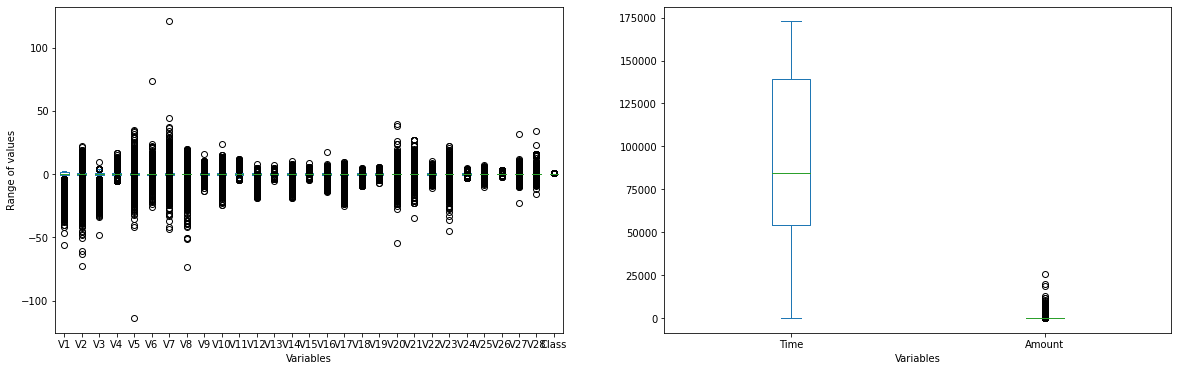

In [3]:
import matplotlib.pyplot as plt

#Boxplots
fig, ax = plt.subplots(ncols=2, figsize=(20,6))

df.drop(['Time', 'Amount'], axis=1).plot.box( ax = ax[0])
df[['Time', 'Amount']].plot.box( ax = ax[1])
ax[0].set_xlabel("Variables")
ax[0].set_ylabel("Range of values")
ax[1].set_xlabel("Variables")

+ The boxplots shows more clearly the distributions of the variables. 
+ Some variables seem to be skeweed like V1-V4 and Amount. 
+ Most of the variables have outliers, some with farther outliers such as V5, V6 and V7. 
+ **An approach to clean the data would be to correct the skewness and remove outliers from the variables. Nevertheless, due to the scope of the kernel this step is not performed as well as a correlation matrix to perform a multivariate analysis.**

### Data Imbalance

In [4]:
counts = df.Class.value_counts()
print(f'None-Fraud Cases: {counts[0]:,} and Fraud Cases: {counts[1]:,}')
print(f'None-Fraud Cases: {round(counts[0]/len(df)*100,2):,}% and Fraud Cases: {round(counts[1]/len(df)*100,2):,}%')

None-Fraud Cases: 284,315 and Fraud Cases: 492
None-Fraud Cases: 99.83% and Fraud Cases: 0.17%


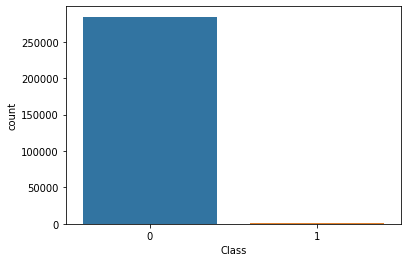

In [5]:
import seaborn as sns

ax = sns.countplot(x="Class", data=df)

+ There is a huge difference between the proportion of None-Fraud vs Fraud Cases

## **Data Preparation**

### Scaling data

This step is performed to make all the variables have the mean of zero and standard deviation of 1. Some models from sklearn require it because their computations are very sensitive to the range of data points. Specifically the models that work with gradient descent. Both models used in this kernel use gradient descent.

Text(0.5, 0, 'Variables')

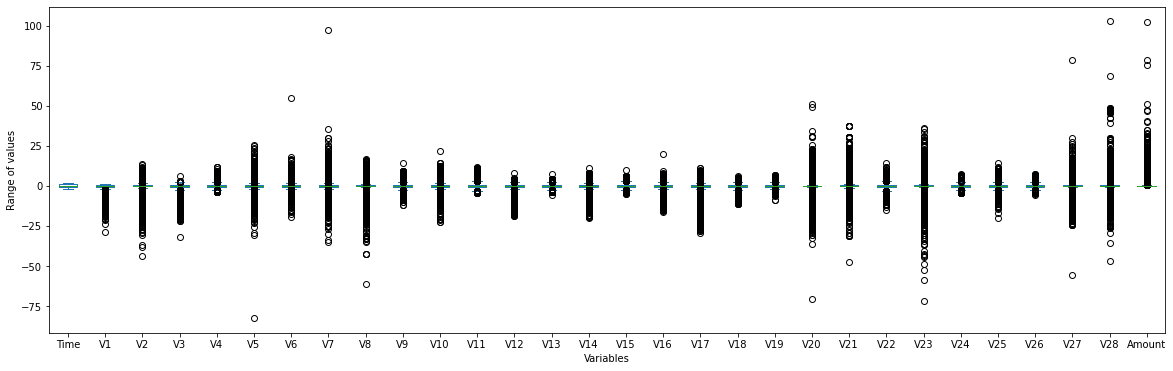

In [6]:
#Credit Card SMOTE
from sklearn import preprocessing

scaled_values = preprocessing.scale(df.drop('Class', axis = 1).values)
df_scaled = pd.DataFrame(data=scaled_values, columns = df.drop('Class', axis = 1).columns)
df_scaled['Class'] = df.Class

#Boxplots
fig, ax = plt.subplots(figsize=(20,6))

df_scaled.drop('Class', axis = 1).plot.box(ax = ax)
ax.set_xlabel("Variables")
ax.set_ylabel("Range of values")
ax.set_xlabel("Variables")

### Class average behavior

In [7]:
import plotly.graph_objects as go

df_profile = df_scaled.groupby('Class').mean()
categories = df_profile.columns

#Plot 
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
        r= df_profile.iloc[0].to_list(),
        theta=categories,
        fill='toself',
        name='Genuine\'s area'
))

fig.add_trace(go.Scatterpolar(
        r=df_profile.iloc[1].to_list(),
        theta=categories,
        fill='toself',
        name='Fraud\'s area'
))

fig.show()

### Split Data

In [8]:
from sklearn.model_selection import train_test_split

y = df_scaled.Class
X = df_scaled.drop('Class', axis = 1)

#Setting up testing and traning sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=27)

#Setting up the train and validation test
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.25, random_state=27)

In [8]:
print('Train instances: {}, None_Fraud: {} and Fraud: {}'.format(len(y_train),
                                                                         y_train.value_counts()[0],
                                                                         y_train.value_counts()[1]))

print('Val instances: {}, None_Fraud: {} and Fraud: {}'.format( len(y_val), 
                                                                         y_val.value_counts()[0],
                                                                         y_val.value_counts()[1]))

print('Test instances: {}, None_Fraud: {} and Fraud: {}'.format( len(y_test),
                                                                         y_test.value_counts()[0],
                                                                         y_test.value_counts()[1]))

Train instances: 160203, None_Fraud: 159945 and Fraud: 258
Val instances: 53402, None_Fraud: 53300 and Fraud: 102
Test instances: 71202, None_Fraud: 71070 and Fraud: 132


The data is splitted in three sets
   + Train instances to train the model. 
   + Val instances to validate the model if required. 
   + And the Test instances to evaluate the model. 

## **Cost Approach**

The following approach to compute the cost of a model is based on the technique used in this Kaggle kernel[1]. 

**The technique is the following:**
+ It uses the False Positive (type I error) and False Negatives (type II error) from the confusion matrix of the tested model
+ **It defines a cost for both errors based on business information**
+ The computation is nothing more than the sum of the products of the errors times the costs
+ Equation:
    + $Cost = (FalsePostives * CostFalse Positives) + (FalseNegatives* CostFalse Negatives)$

In [9]:
def cost_eq(fp,fn,costs): 
    """
    Function that computes the cost of the errors of a model
    
    Parameters:
    -----------
    fp: number of false positives
    fn: number of false negatives
    """
    return fp*costs['avg_analysis_cost'] + fn*costs['avg_fraud_cost']

def cost_computation(conf_matrix, costs):
    """
    Function that recieves the confusion matrix of a model and the cost and returns the cost of the model
    
    Parameters:
    ----------
    conf_matrix: confusion matrix of the model tested
    costs: dict with the costs errors and test ratio
    """
    false_positives = conf_matrix[0,1]
    false_negatives = conf_matrix[1,0] 
    
    cost = cost_eq(false_positives, false_negatives, costs)
    TEST_RATIO = costs['test_ratio']
    
    validation_cost = f'The misclassification cost on this validation set, {TEST_RATIO * 100}% of data, is € {cost:,.2f}'
    #estimation_cost = f'\nExtrapolated to an entire day\'s worth of transactions, (/{TEST_RATIO}/2 days), we get ~ $ {cost/TEST_RATIO/2:,.2f}'
    
    return validation_cost 
   

**This approach is a simplification of the Expected Value Framework from [2]**
+ The framework computes expected value for one instance classified by a model
+ It is based on calculating the sum of the product of the confusion matrix times the cost/benefit matrix
+ The cost/benefit matrix is defined by the business
    + It helps to define the benefit of True Positives and True Negatives
+ The framework can be adapted to take into account the prior distributions of datasets, which can be helpful for validating models trained with imbalanced datasets. This approach will be used in future kernels.

+ The equation is the following:
    + $ExpectedValue = p(Y,p)*b(Y,p)+ p(N,n)*b(N,n)+ p(Y,n)*c(Y,n) + p(N,p)*c(N,p)$

Where: 
   + **$p(outcome)$** are the probabilities of the outcomes of the model, they are obtained with the normalization of the confusion matrix
   + **$b(outcome)$** are the benefits of the outcomes, they are defined by the business (may come from different source of data)
   + **$c(outcome)$** are the cost of the outcomes, they are defined by the business (may come from different source of data)
   
And the outcomes can be interpreted with the following confusion matrix:

|   | p      | n      |
|---|--------|--------|
| Y | b(Y,p) | c(Y,n) |
| N | c(N,p) | b(N,n) |

Where: 
+ p = positive
+ n = negative
+ Y = predicted positive
+ N = predicted negative
+ b = benefit
+ c = cost


This kernel does not uses the benefits nor the probabilities.

### Problem Assumptions

**This notebook considers the following:**
+ There is no benefit if we predict correctly the True Postive and True Negative (TP and TN).
+ There is only a cost for both errors False Positive (FP) or c(Y,n) and False Negative (FN) or c(N,p).
    + **The FP is when a not-fraud transaction is detected as fraud (false alarm)**
    + **The FN is when a fraud transaction is detected as non-fraud**


Thus, both errors are defined as:
+ **FP: the cost of anaylizing the transaction**
+ **FN: the cost of reimbursing the money lost in the fraud**

For the sake of simplicity:
+ FP = 3 EUR ( can be cost of a person or an algorithm to analyse the transaction, similar value as the found in this kernel [1] which is determined by the business)
+ FN = average cost of frauds ->  Get from the data

In [10]:
#The average cost of the fraud
avg_fraud_cost = df.groupby('Class')['Amount'].mean()[1]
round(avg_fraud_cost,0)

122.0

Thus the error costs are:
+ **FP = 3 EUR** 
+ **FN = 122 EUR**

In [11]:
costs = {
    'avg_analysis_cost':3 ,
    'avg_fraud_cost':122 ,
    'test_ratio':0.25
}

### Marginal Cost

In [12]:
#From cost kaggle example (marginal terminology)!!!!
ratio = round(costs['avg_fraud_cost']/costs['avg_analysis_cost'],0)
print( 'Ratio= 1:{0}, this means that after {0} False Positives, it was not worth catching an extra fraud'.format(ratio)) 

Ratio= 1:41.0, this means that after 41.0 False Positives, it was not worth catching an extra fraud


### Marginal plot

The following plot shows the gains and losses based on the false positive for catching an extra fraud. This plot is based on the proposed in [1].

In [14]:
import plotly.express as px
import numpy as np

count_of_false_positives = np.arange(0, costs['avg_fraud_cost'] / costs['avg_analysis_cost'] * 2)
marginal_cost_function = count_of_false_positives * -costs['avg_analysis_cost'] + costs['avg_fraud_cost'] 
intersect = int(costs['avg_fraud_cost']  / costs['avg_analysis_cost'])


#Plot
fig = px.line( x=count_of_false_positives, 
	y=marginal_cost_function)

fig.add_trace(
	go.Scatter(	
		mode = 'markers',
		x = [intersect],
		y = [0],
		marker=dict(
			color='red',
			size=10,
			),
		showlegend=False,
		name = 'Intersection'
		))

fig.update_layout(
	yaxis_title="Amount in €",
	xaxis_title="Number of false alarm",
	title_text= "Marginal gain per extra fraud caught",
	title_x=0.5
	)

fig.show()

In [15]:
print(f'After {intersect} false alarms, it wasn\'t worth catching the extra fraud.')

After 40 false alarms, it wasn't worth catching the extra fraud.


### Cost of doing nothing

In [16]:
cost_of_do_nothing = costs['avg_fraud_cost']*df.Class.value_counts()[1]
print(f'Reimbursing all fraud would be on average cost ~ € {round(cost_of_do_nothing/2,1):,} / day')

Reimbursing all fraud would be on average cost ~ € 30,012.0 / day


### Cost of checking all the transactions

In [17]:
cost_of_checking_all = costs['avg_analysis_cost']*len(df) 
print(f'Cost of checking all transactions would be on average ~ € {round(cost_of_checking_all/2,1):,} / day')

Cost of checking all transactions would be on average ~ € 427,210.5 / day


## **Modeling**

### Baseline model

The purpose of this model is to have a baseline to show a model with bad performance. In this case it is simulating a model which always predicts the same label due to the imbalanced dataset. 

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
import numpy as np

#DummyClassifiert to predict only target 0
dummy = DummyClassifier(strategy='most_frequent', random_state=42).fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

#Get confusion matrix
cm_base = confusion_matrix(y_test, dummy_pred)


#Get the costs
cost_computation(cm_base, costs)

'The misclassification cost on this validation set, 25.0% of data, is € 16,104.00'

### Logistic Regression model

This model works applies a better algorithm than the dummy

In [19]:
from sklearn.linear_model import LogisticRegression

#Logistic regression model
logreg = LogisticRegression().fit(X_train.values, y_train.values)
logreg_pred = logreg.predict(X_test.values)

#Get confusion matrix
cm_logreg = confusion_matrix(y_test, logreg_pred)

#Get the costs
cost_computation(cm_logreg, costs)

'The misclassification cost on this validation set, 25.0% of data, is € 5,755.00'

### XGBoost Model

As mentioned before this model is more complex than Logistic Regression, thus better results are expected

In [20]:
import xgboost as xgb

#Extreme Gradient Boosting
xgboost = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'aucpr',use_label_encoder = False).fit(X_train.values, y_train.values)
xgboost_pred = xgboost.predict(X_test.values)

#Get confusion matrix
cm_xgboost = confusion_matrix(y_test, xgboost_pred)

#Get the costs
cost_computation(cm_xgboost, costs)

'The misclassification cost on this validation set, 25.0% of data, is € 3,178.00'

The results of Logistic Regression and XGBoots reduced efficaciously the cost, specifically the case of XGBoost. In this fashion another technique will be used to try reducing the costs more.

## **Dealing with Imbalanced Datasets**

### Resampling data

Resampling the data is one of the most repeated concepts present in the books to solve the problem of imbalancing. There are several techniques to do it such as: sub-sampling the mayority class, over-sampling de minority class (by repeating instances, by repeating instances + a random noise, by creating synthetic instances). From a few kernels, articles (medium, towardsdatascience, kdnuggets), books reviewed a technique that provide great results is the synthetic creation of instances using Synthetic Minority Over-sampling Technique (SMOTE)[1,3,4,5,6,7,8].


In [21]:
#SMOTE
from imblearn.over_sampling import SMOTE

fraud_weight = round(costs["avg_fraud_cost"] / costs["avg_analysis_cost"], 1)
fraud_in_train_set = y_train.sum()

sm = SMOTE(random_state=27, sampling_strategy= {1: int(fraud_in_train_set * fraud_weight)})
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

print(y_train_smote.value_counts())

0    159945
1     10500
Name: Class, dtype: int64


#### Testing SMOTE on Logistic Regression and XGBoost

In [22]:
#Logistic regression model
logreg_sm = LogisticRegression().fit(X_train_smote.values, y_train_smote.values)
logreg_sm_pred = logreg_sm.predict(X_test.values)

#Get confusion matrix
cm_logreg_sm = confusion_matrix(y_test, logreg_sm_pred)

#Get the costs
cost_computation(cm_logreg_sm, costs)

'The misclassification cost on this validation set, 25.0% of data, is € 2,882.00'

In [23]:
#Extreme Gradient Boosting
xgboost_sm = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'aucpr', use_label_encoder = False).fit(X_train_smote.values,
                                                                                      y_train_smote.values)
xgboost_sm_pred = xgboost_sm.predict(X_test.values)

#Get confusion matrix
cm_xgboost_sm = confusion_matrix(y_test, xgboost_sm_pred)

#Get the costs
cost_computation(cm_xgboost_sm, costs)

'The misclassification cost on this validation set, 25.0% of data, is € 3,086.00'

Logistic Regression reduced more than a half its cost. On the other side, XGBoost only reduced only a small portion of its cost. Let's try if selecting the best variables can improve the performance of the models.

## **Improving the Model**

### Feature Selection

+ The technique used is the Recursive Feature Elimination

#### Logistic Regression

In [24]:
#RFE for Logistic Regression
from sklearn.feature_selection import RFE

rfe_logreg = RFE(estimator=LogisticRegression(), step=1)
rfe_logreg.fit(X_train_smote.values, y_train_smote.values)

sel_vars = list(X_train_smote.columns[rfe_logreg.support_])

In [25]:
#Selected variables
print(sel_vars)

['Time', 'V1', 'V4', 'V5', 'V7', 'V9', 'V10', 'V12', 'V13', 'V14', 'V20', 'V22', 'V26', 'V27', 'Amount']


In [26]:
#Logistic regression model
logreg_sm_rfe = LogisticRegression().fit(X_train_smote[sel_vars].values, y_train_smote.values)
logreg_sm_rfe_pred = logreg_sm_rfe.predict(X_test[sel_vars].values)

#Get confusion matrix
cm_logreg_sm_rfe = confusion_matrix(y_test, logreg_sm_rfe_pred)

#Get the costs
cost_computation(cm_logreg_sm_rfe, costs)

'The misclassification cost on this validation set, 25.0% of data, is € 3,049.00'

The selection of variable did not help to improve the cost of the model, it increased a little the cost. 

#### XGBoost

In this case the step was changed to 3, this means that each iteration the technique will try to reduce 3 variables. This was selected because the model takes to much time trainig and the technique has to train the model and get metrics every single iteration.

In [27]:
rfe_xgb = RFE(estimator=xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'aucpr',use_label_encoder = False), step=3)
rfe_xgb.fit(X_train_smote.values, y_train_smote.values)

sel_vars_xgb = list(X_train_smote.columns[rfe_xgb.support_])

In [28]:
#Extreme Gradient Boosting
xgboost_sm_rfe = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'aucpr', use_label_encoder = False).fit(X_train_smote[sel_vars_xgb].values,
                                                                                      y_train_smote.values)
xgboost_sm_rfe_pred = xgboost_sm_rfe.predict(X_test[sel_vars_xgb].values)

#Get confusion matrix
cm_xgboost_sm_rfe = confusion_matrix(y_test, xgboost_sm_rfe_pred)

#Get the costs
cost_computation(cm_xgboost_sm_rfe, costs)

'The misclassification cost on this validation set, 25.0% of data, is € 3,113.00'

The same case happened to XGBoost. **Even though both cost of the models did not improve, the selected variables will be kept to reduce the complexity of the models. Recalling the Occam Razor's principle, that the best model is the simplest**[9]. In order to confirm if the feature selection helped, then the same technique can be used with cross-validation. This method is contained in the sklearn library as well. The only disadvantage is that it will take more time for XGBoost to find the best variables, which is out of the scope of this kernel. The following part of the kernel will try to improve the results by tunning the hyperparameters.

### Hyperparameters tunning

#### Logistic Regression

The following code uses gridsearch to find the best parameters for the model. The scoring used was f1 which is the weigthed average of precision and recall. It is better to use precision and recall metrics to evaluate the performance of models using imbalanced datasets[9].


In [29]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression 
log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], }
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, scoring = 'f1',return_train_score = True)
grid_log_reg.fit(X_train_smote[sel_vars].values, y_train_smote.values)

# We automatically get the logistic regression with the best parameters.
logreg_sm_rfe_hyp = grid_log_reg.best_estimator_
print(grid_log_reg.best_params_ )

{'C': 0.001, 'penalty': 'l2'}


In [30]:
#Logistic regression model
logreg_sm_rfe_hyp_pred = logreg_sm_rfe_hyp.predict(X_test[sel_vars].values)

#Get confusion matrix
cm_logreg_sm_rfe_hyp = confusion_matrix(y_test, logreg_sm_rfe_hyp_pred)

#Get the costs
cost_computation(cm_logreg_sm_rfe_hyp, costs)

'The misclassification cost on this validation set, 25.0% of data, is € 2,920.00'

The cost was reduced. Tunning the model improved its performance.

#### XGBoost

In [31]:
# XGBoost
xgb_params = {'learning_rate': [0.05,0.01], #0.05 y 0.01
                  'max_depth': [2,8], #8 y 32
                  'random_state': [17],
                  'n_estimators': [50,100],
                  'objective' :  ['binary:logistic'],
                  'eval_metric' : ['aucpr']
             }
grid_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder = False), xgb_params, scoring = 'f1')
grid_xgb.fit(X_train_smote[sel_vars_xgb].values, y_train_smote.values)

print(grid_xgb.best_params_)

{'eval_metric': 'aucpr', 'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'objective': 'binary:logistic', 'random_state': 17}


In [32]:
#Extreme Gradient Boosting
xgboost_sm_rfe_hyp = xgb.XGBClassifier(objective = 'binary:logistic', 
                                  eval_metric = 'aucpr',
                                 learning_rate = 0.05,
                                 max_depth = 8 ,
                                 n_estimators = 100,
                                 random_state = 17).fit(X_train_smote[sel_vars_xgb].values,
                                                                      y_train_smote.values)

xgboost_sm_rfe_hyp_pred = xgboost_sm_rfe_hyp.predict(X_test[sel_vars_xgb].values)

#Get confusion matrix
cm_xgboost_sm_rfe_hyp = confusion_matrix(y_test, xgboost_sm_rfe_hyp_pred)

#Get the costs
cost_computation(cm_xgboost_sm_rfe_hyp, costs)

C:\Users\Milara\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



'The misclassification cost on this validation set, 25.0% of data, is € 2,756.00'

**For both models the cost was improved.** In the case of XGBoost the tunning of the hyperameters was short, the model has many other paramters than can be tunned, but this is outside of the scope of this kernel because it will take more time and resources to do it.

## **Understanding the Performance of the Models**

### Fitting Curves

#### Logistic Regression

The fitting curve is used to measure if making more complex the model overfit the data. The goal of the following graphs is to analyse if increasing the complexity of the model makes the model learn completely the training data causing a drop in the score of the metric in the test dataset, in other words to measure the bias-variance trade off.

+ In the case of Logistic Regression there is no complexity to be increased, but at least the the regularization parameter can be evaluated. 
+ It was decided to see the curves for recall and precision because there are the metrics that arise the impact of the FP and FN [9]. 

In [33]:
# Logistic Regression 
scoring_list = ['precision','recall']
cv_logreg_sum = pd.DataFrame(data = {"param_C": [], "mean_train_score":[],
                                     "mean_test_score":[] ,  "Scoring":[]})

for elem in scoring_list:
    log_reg_params = {"penalty": ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params, scoring = elem, return_train_score = True)
    grid_log_reg.fit(X_train_smote[sel_vars], y_train_smote)
    cv_res_logreg = pd.DataFrame(grid_log_reg.cv_results_)
    cv_logreg = cv_res_logreg[['param_C','mean_train_score','mean_test_score']]
    cv_logreg.insert(0, 'Scoring', elem)
    cv_logreg_sum = pd.concat([cv_logreg_sum,cv_logreg], axis = 0)                                 

Text(0.5, 1.0, 'Fitting graph for recall')

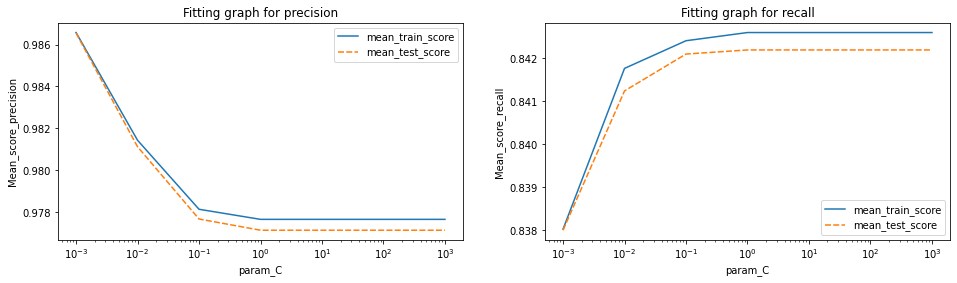

In [34]:
#Precision Fitting Graph
cv_logreg_pre =cv_logreg_sum[cv_logreg_sum['Scoring']=='precision'][['param_C',
                                                         'mean_train_score','mean_test_score']]

cv_logreg_pre.index =  cv_logreg_pre['param_C']
cv_logreg_pre.drop('param_C', axis =1, inplace = True)

#Recall Fitting Graph
cv_logreg_rec =cv_logreg_sum[cv_logreg_sum['Scoring']=='recall'][['param_C',
                                                         'mean_train_score','mean_test_score']]

cv_logreg_rec.index =  cv_logreg_rec['param_C']
cv_logreg_rec.drop('param_C', axis =1, inplace = True)

#Plot both graphs
fig, ax = plt.subplots( ncols=2, figsize = (16,4))


sns.lineplot(data=cv_logreg_pre,  ax = ax[0])
ax[0].set(xscale="log")
ax[0].set_ylabel('Mean_score_precision')
ax[0].set_title('Fitting graph for precision')


sns.lineplot(data=cv_logreg_rec,  ax = ax[1])
ax[1].set(xscale="log")
ax[1].set_ylabel('Mean_score_recall')
ax[1].set_title('Fitting graph for recall')

The x axis in both graphs shows the parameter C, if the parameter is close to zero then regularization is stronger. **From both graphs there is no signal of overfitting the data as the C parameter is increased**. Furthermore, it seems to be a trade of between the precision and recall curves. As the paramter increased the precision is reduced and the recall is increased. 

#### XGBoost

In [35]:
scoring_list = ['precision','recall']
cv_xgb_sum = pd.DataFrame(data = {"param_max_depth": [], "mean_train_score":[],
                                     "mean_test_score":[] ,  "Scoring":[]})

xgb_params = {'learning_rate': [0.05], #0.05 y 0.01
                  'max_depth': [2,5,10,20,50,100], #8 y 32
                  'random_state': [17],
                  'n_estimators': [100],
                  'objective' :  ['binary:logistic'],
                  'eval_metric' : ['aucpr']
             }

for elem in scoring_list:
    grid_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder = False), xgb_params, scoring = elem, cv = 2,return_train_score = True)
    grid_xgb.fit(X_train_smote[sel_vars_xgb], y_train_smote)
    cv_xgb_res = pd.DataFrame(grid_xgb.cv_results_)
    cv_xgb = cv_xgb_res[['param_max_depth','mean_train_score','mean_test_score']]
    cv_xgb.insert(0, 'Scoring', elem)
    cv_xgb_sum = pd.concat([cv_xgb_sum,cv_xgb], axis = 0)  

Text(0.5, 1.0, 'Fitting graph for recall')

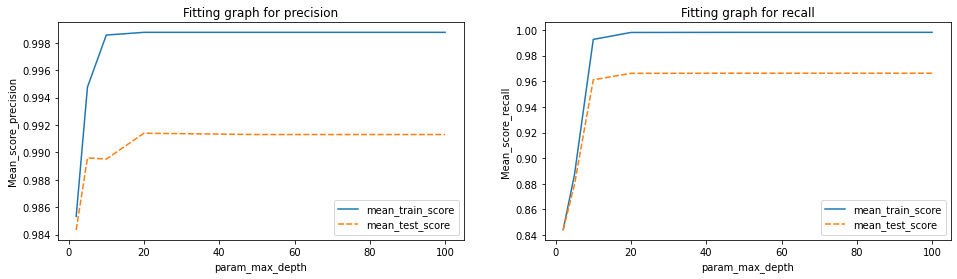

In [36]:
#Precision Fitting Graph
cv_xgb_pre =cv_xgb_sum[cv_xgb_sum['Scoring']=='precision'][['param_max_depth',
                                                         'mean_train_score','mean_test_score']]

cv_xgb_pre.index =  cv_xgb_pre['param_max_depth']
cv_xgb_pre.drop('param_max_depth', axis =1, inplace = True)

#Recall Fitting Graph
cv_xgb_rec =cv_xgb_sum[cv_xgb_sum['Scoring']=='recall'][['param_max_depth',
                                                         'mean_train_score','mean_test_score']]

cv_xgb_rec.index =  cv_xgb_rec['param_max_depth']
cv_xgb_rec.drop('param_max_depth', axis =1, inplace = True)

#Plot both graphs
fig, ax = plt.subplots( ncols=2, figsize = (16,4))

sns.lineplot(data=cv_xgb_pre,  ax = ax[0])
ax[0].set_ylabel('Mean_score_precision')
ax[0].set_title('Fitting graph for precision')

sns.lineplot(data=cv_xgb_rec,  ax = ax[1])
ax[1].set_ylabel('Mean_score_recall')
ax[1].set_title('Fitting graph for recall')

**Both graphs do not show any signal of overfitting, there is no drop of test score due to the increment of the parameter.** This also can be due to the nature of the model that the paramter is the max depth which it does not mean that the model will use all the depth, but in does have an impact because between the 2 to 20 there is an improvement on the metrics. Moreover, there is no trade off between precision and recall. 

### Learning and Scalability Curves

In [37]:
#Function from:
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,scoring='f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid(b=True)
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid(b=True)
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid(b=True)
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


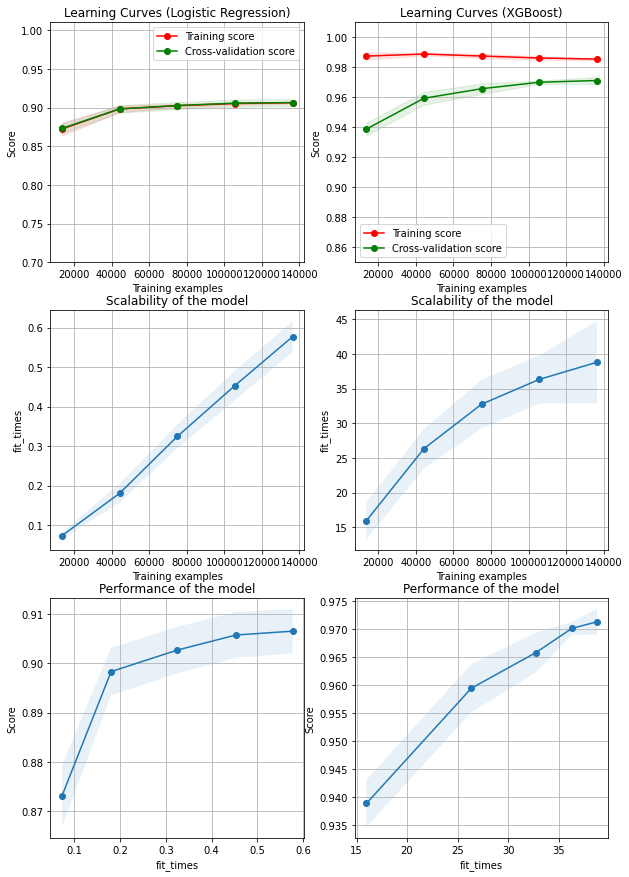

In [38]:
#Make the plots, this code takes to run
fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
                                        
plot_learning_curve(LogisticRegression(penalty='l2', C=0.001), title, 
                    X_train_smote[sel_vars], y_train_smote, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (XGBoost)"
# XGBoost is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = xgb.XGBClassifier(objective='binary:logistic',
                              max_depth=8,
                              n_estimators=100,
                              learning_rate=0.05,
                              eval_metric='aucpr')
plot_learning_curve(estimator, title, X_train_smote[sel_vars_xgb], 
                    y_train_smote, axes=axes[:, 1], ylim=(0.85, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

    
+ From the test and traning learning curves, Logistic Regression needs around 20,000 instances to almost reach its maximum score of f1 but XGBoost seems to be improving the score by adding more data. Furthermore, **XGBoost with 20,000 instances reaches a higher score than Logistic Regression.**
+ From the training samples vs fit times, it can be seen that **XGBoost takes more time processing the same number of instances as Logistic Regression**, to process 140,000 instances Logistic Regression takes almost 0.6 seconds while XGBoost requires between 30 to 40 seconds.
+ From the fit times vs score, **XGBoost takes far more time to reach it highest score.**
+ Functions for plotting the curves obtained from [12].

These graphs help to make decision based on the available resources. **If there are plenty resources for computation and time then XGBoost is a good option, but if they are limited then Logistic Regression stills provide nice results.** However, there are other metrics that can be used to select which model is better. The following section finds the threshold that minimizes the cost for both models

### Misclassification Cost per threshold

Functions for plotting obtained from [1]. The following graphs shows the threshold that minimizes the costs based on the different errors the models generate. This is an ideal method to find the minimum cost.

In [39]:
def cost_per_threshold(sklearn_classifier, X, y, costs):
    """ return four lists:
            1) list of thresholds (defined in this function) 
            2) count of false negatives (uncaught fraud)
            3) count of false positives (overreported transactions)
            4) total cost per threshold iteration
    """
    
    # shorter variable
    clf = sklearn_classifier
    
    # lists to be passed to plot
    thresholds = np.arange(start=0.05, stop=1, step=0.025)
    fn, fp = [], []

    # looping through thresholds to plot cost curve
    for threshold in thresholds:

        # custom threshold
        y_pred = (clf.predict_proba(X)[:,1] > threshold).astype(int)

        # extracting performance indicators
        false_positives = confusion_matrix(y, y_pred)[0,1]
        false_negatives = confusion_matrix(y, y_pred)[1,0]

        # add to lists
        fp.append(false_positives)
        fn.append(false_negatives)

    # convert to numpy arrays
    fp = np.asarray(fp)
    fn = np.asarray(fn)
    c = cost_eq(fp, fn, costs)
    
    # return values
    return thresholds, fp, fn, c

In [40]:
def plot_misclassification(thresholds, fp, fn, c):
    
    # two y-axes sharing the same plot
    fig, (left, right) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    """ LEFT PLOT """
    left.title.set_text('Misclassification Counts')

    # 1st y-axis
    color = 'tab:orange'
    left.set_xlabel('threshold')
    left.set_ylabel('false positives', color=color)
    left.plot(thresholds, fp, color=color)
    left.tick_params(axis='y', labelcolor=color)

    # 2nd y-axis
    left_2nd_y = left.twinx() # share the same x-axis
    color = 'tab:red'
    left_2nd_y.set_ylabel('false negatives', color=color) 
    left_2nd_y.plot(thresholds, fn, color=color)
    left_2nd_y.tick_params(axis='y', labelcolor=color)


    """ RIGHT PLOT """
    right .title.set_text('Misclassification Costs')

    # plotting costs
    color = 'tab:blue'
    right.set_xlabel('threshold')
    right.set_ylabel('total ($)', color=color)
    right.plot(thresholds, c, color=color)
    right.tick_params(axis='y', labelcolor=color)

    
    """ ANNOTATE """
    # calculate minimum cost threshold
    optimal_threshold = min(zip(thresholds, c), key=lambda t: t[1])
    optimal_threshold_index = np.where(thresholds==optimal_threshold[0])[0] 
    optimal_threshold_fp = fp[optimal_threshold_index]
    optimal_threshold_fn = fn[optimal_threshold_index]
    
    right.plot(*optimal_threshold, 'go');
    
    # display cost optimum
    print(f'The cost minimum occurs at threshold {optimal_threshold[0]:.3f}, where the misclassification are as follows')
    print(f'    False positives: {optimal_threshold_fp}')
    print(f'    False negatives: {optimal_threshold_fn}')
    print('')
    print(f'Misclassification costs on test sample: {optimal_threshold[1]:,.2f}')
    print(f'Extrapolated daily cost: {optimal_threshold[1]/TEST_RATIO/2:,.2f}')
    
    """ DISPLAY """
    # prevent clipping and overlap between graphs
    fig.tight_layout()  
    plt.show();
    return optimal_threshold[0]

In [41]:
TEST_RATIO = costs['test_ratio']

#### Logistic Regression

C:\Users\Milara\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

C:\Users\Milara\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

C:\Users\Milara\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

C:\Users\Milara\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

C:\Users\Milara\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:434: UserWarning:

X has feature names, but LogisticRegression was fitted without feature names

C:\Users\Milara\AppData\Local\Programs\Python\Python39\lib\site-packag

The cost minimum occurs at threshold 0.375, where the misclassification are as follows
    False positives: [65]
    False negatives: [22]

Misclassification costs on test sample: 2,879.00
Extrapolated daily cost: 5,758.00


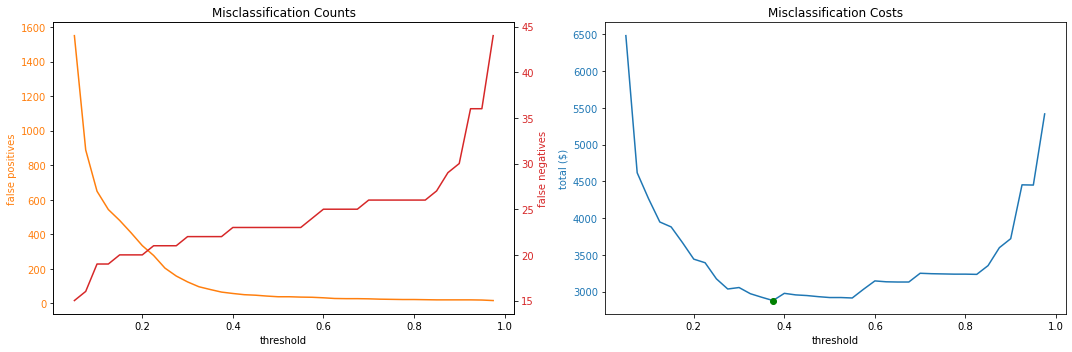

In [42]:
# compute results at each threshold level
thresholds, fp, fn, c = cost_per_threshold(logreg_sm_rfe_hyp, X_test[sel_vars], y_test, costs)

# visualise them
logreg_best_thres = plot_misclassification(thresholds, fp, fn, c)

#### XGBoost

The cost minimum occurs at threshold 0.525, where the misclassification are as follows
    False positives: [21]
    False negatives: [22]

Misclassification costs on test sample: 2,747.00
Extrapolated daily cost: 5,494.00


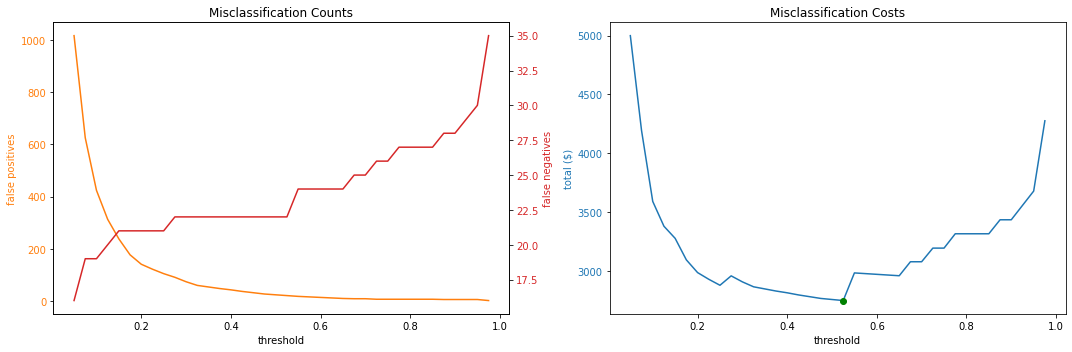

In [43]:
# compute results at each threshold level
thresholds, fp, fn, c = cost_per_threshold(xgboost_sm_rfe_hyp, X_test[sel_vars_xgb], y_test, costs)

# visualise them
xgb_best_thres = plot_misclassification(thresholds, fp, fn, c)

### Cost/Profit Curves

**This kind of plot helps to determine which model to use when there is restriction on budget**. The graph is computed as following:

- The probabities of being the positive class is calculated for the instances of the test data using model.predict_proba 
- The probabilities are sorted in descending order, meaning that the first instances are the ones with the highest probability of being the positive class (a fraud)
- Then the probabilities are used to assign the class of the instances based on a threshold (already computed)
- Then the FP and FN errors are calculated
- Finally, the cummulative cost is computed. The cummulative cost helps to understand the loss if the selection of instances (based on their probabilites) are targeted in order.
- The x axis shows the number of instances and the y axis shows the cummulative cost

**The goal of the plot is to select the model that uses better the budget.** 


In [44]:
def error_cost(y_pred,y_test,costs):
    """
    Returns the costs of the error
    
    Parameters:
    -----------
    y_pred: classes estimated by the classifier
    y_test: actual classes
    costs: costs of the errors
    """
    if y_pred == 1 and y_test == 1:
        return costs['avg_analysis_cost']
    if y_pred == 1 and y_test==0:
        return costs['avg_analysis_cost']
    elif y_pred== 0 and y_test==1:
        return costs['avg_fraud_cost'] 
    else:
        return 0
    
def compute_cost_df(y_proba,y_test,best_thres,costs):
    """
    Generates a df with the cummulative cost of the errors
    
    Parameters:
    ------------
    y_proba: array with the probabilities of X_test given by an estimator
    y_test: array with the actual values of y
    best_thres: int best threshold to define a binary outcome
    costs: dict with the costs of the errors
    """
    #Build the df for the cost curve
    df_cost_curve = pd.DataFrame({'y_proba':y_proba, 
                                         'y_pred': np.where(y_proba > best_thres,1,0),
                                         'y_test':y_test})

    #Sort df by probability
    df_cost_curve = df_cost_curve.sort_values(by='y_proba'
                                                            , ascending = False).reset_index().drop('index', axis =1)

    #Compute the cost of each error
    df_cost_curve['cost'] = df_cost_curve.apply(lambda x: error_cost(x.y_pred, x.y_test,costs), axis=1)

    #Compute the cummulative sum of the costs
    df_cost_curve['cum_cost'] = df_cost_curve['cost'].cumsum(axis=0)
    
    return df_cost_curve

#### Logistic Regression curve computation

In [45]:
#Threshold from previous analysis
print(logreg_best_thres)

#Get the probabilities for each instance based on the estimator
logreg_y_proba = logreg_sm_rfe_hyp.predict_proba(X_test[sel_vars].values)[:,1]

df_logreg_thrs_cost_curve = compute_cost_df(logreg_y_proba,y_test,logreg_best_thres,costs)

0.3750000000000001


#### XGBoosting computation

In [46]:
#Threshold from previous analysis
print(xgb_best_thres)

#Get the probabilities for each instance based on the estimator
xgb_y_proba = xgboost_sm_rfe_hyp.predict_proba(X_test[sel_vars_xgb].values)[:,1]

df_xgboost_thrs_cost_curve = compute_cost_df(xgb_y_proba,y_test,xgb_best_thres,costs)

0.5250000000000001


#### Plot Cost Curves

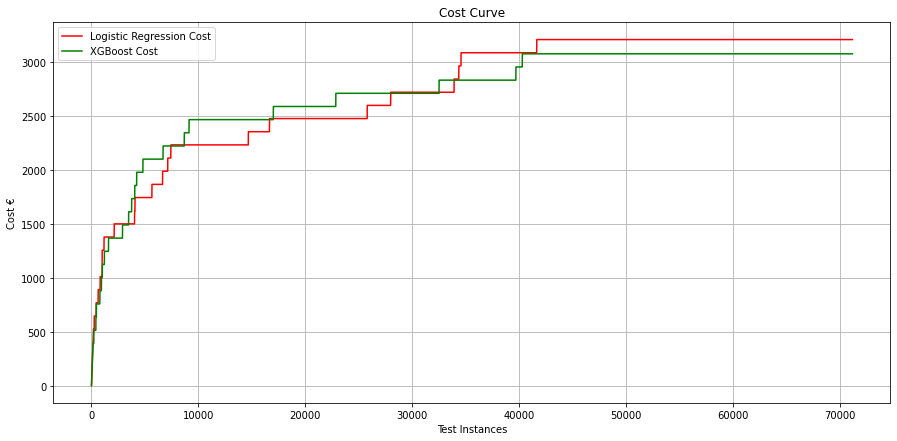

In [47]:
_, axes = plt.subplots(figsize=(15, 7))

instances=np.arange(0, len(y_test))

axes.set_title("Cost Curve")
axes.set_xlabel("Test Instances")
axes.set_ylabel("Cost €")
axes.grid(b=True)
axes.plot(instances, df_logreg_thrs_cost_curve['cum_cost'].values, '-', color="r",label="Logistic Regression Cost")
axes.plot(instances, df_xgboost_thrs_cost_curve['cum_cost'].values, '-', color="g",label="XGBoost Cost")
axes.legend(loc="best")


plt.show()

**The plot shows that both models behave similarly**. At the end they generate similar costs after analyzing more than 7,000 instances never seen before. So, in this case any model would work, so the decision could be based on other metric relevant for the business such as computation cost. However, to clarify the idea of the plot the next section shows the comparison of all the models generated in this kernel. Furthermore the following section shows the curves for all of the models generated in this notebook.

### Cost curves for all models

The goal of this plot is to compare the performances of the models that were improved gradually.


In [48]:
#Dummy model 
dummy_proba = dummy.predict_proba(X_test.values)[:,1]
df_dummy_cost_curve = compute_cost_df(dummy_proba,y_test,0.5,costs)

#Simple Logistic Regression
logreg_proba = logreg.predict_proba(X_test.values)[:,1]
df_logreg_cost_curve = compute_cost_df(logreg_proba,y_test,0.5,costs)

#Simple XGBoost
xgboost_proba = xgboost.predict_proba(X_test.values)[:,1]
df_xgboost_cost_curve = compute_cost_df(xgboost_proba,y_test,0.5,costs)

#SMOTE Logistic Regression
logreg_sm_proba = logreg_sm.predict_proba(X_test.values)[:,1]
df_logreg_sm_cost_curve = compute_cost_df(logreg_sm_proba,y_test,0.5,costs)

#SMOTE XGBoost 
xgboost_sm_proba = xgboost_sm.predict_proba(X_test.values)[:,1]
df_xgboost_sm_cost_curve = compute_cost_df(xgboost_sm_proba,y_test,0.5,costs)

#SMOTE RFE Logistic Regression
logreg_sm_rfe_proba = logreg_sm_rfe.predict_proba(X_test[sel_vars].values)[:,1]
df_logreg_sm_rfe_cost_curve = compute_cost_df(logreg_sm_rfe_proba,y_test,0.5,costs)

#SMOTE RFE XGBoost
xgboost_sm_rfe_proba = xgboost_sm_rfe.predict_proba(X_test[sel_vars_xgb].values)[:,1]
df_xgboost_sm_rfe_cost_curve = compute_cost_df(xgboost_sm_rfe_proba,y_test,0.5,costs)

#SMOTE RFE HYP Logistic Regression
logreg_sm_rfe_hyp_proba = logreg_sm_rfe_hyp.predict_proba(X_test[sel_vars].values)[:,1]
df_logreg_sm_rfe_hyp_cost_curve = compute_cost_df(logreg_sm_rfe_hyp_proba,y_test,0.5,costs)

#SMOTE RFE HYP XGBoost
xgboost_sm_rfe_hyp_proba = xgboost_sm_rfe_hyp.predict_proba(X_test[sel_vars_xgb].values)[:,1]
df_xgboost_sm_rfe_hyp_cost_curve = compute_cost_df(xgboost_sm_rfe_hyp_proba,y_test,0.5,costs)

In [49]:
#Store the results of the model in a csv for further analysis
"""
df_tmp = pd.DataFrame({'dummy_proba':dummy_proba,
                      'logreg_proba':logreg_proba,
                      'xgboost_proba': xgboost_proba,
                      'logreg_sm_proba':logreg_sm_proba,
                      'xgboost_sm_proba': xgboost_sm_proba,
                      'logreg_sm_rfe_proba':logreg_sm_rfe_proba,
                      'xgboost_sm_rfe_proba':xgboost_sm_rfe_proba,
                      'logreg_sm_rfe_hyp_proba': logreg_sm_rfe_hyp_proba,
                      'xgboost_sm_rfe_hyp_proba':xgboost_sm_rfe_hyp_proba,
                       'xgb_y_proba':xgb_y_proba,
                      'y_test':y_test})

df_tmp.to_csv("C:/Users/Milara/Desktop/New Projects/FraudDetection/model_results_v1.csv", encoding="ISO-8859-1", index = False)
"""

'\ndf_tmp = pd.DataFrame({\'dummy_proba\':dummy_proba,\n                      \'logreg_proba\':logreg_proba,\n                      \'xgboost_proba\': xgboost_proba,\n                      \'logreg_sm_proba\':logreg_sm_proba,\n                      \'xgboost_sm_proba\': xgboost_sm_proba,\n                      \'logreg_sm_rfe_proba\':logreg_sm_rfe_proba,\n                      \'xgboost_sm_rfe_proba\':xgboost_sm_rfe_proba,\n                      \'logreg_sm_rfe_hyp_proba\': logreg_sm_rfe_hyp_proba,\n                      \'xgboost_sm_rfe_hyp_proba\':xgboost_sm_rfe_hyp_proba,\n                       \'xgb_y_proba\':xgb_y_proba,\n                      \'y_test\':y_test})\n\ndf_tmp.to_csv("C:/Users/Milara/Desktop/New Projects/FraudDetection/model_results_v1.csv", encoding="ISO-8859-1", index = False)\n'

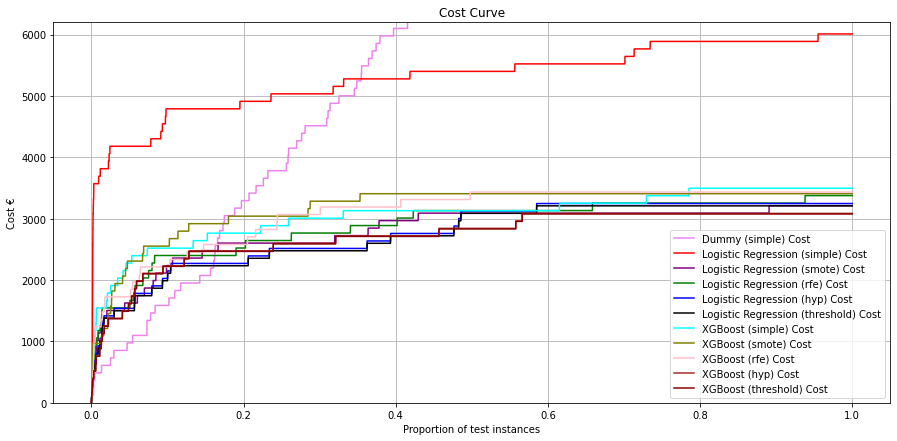

In [50]:
_, axes = plt.subplots(figsize=(15, 7))

instances=np.arange(0, 1, (1/len(y_test)))

axes.set_title("Cost Curve")
axes.set_xlabel("Proportion of test instances")
axes.set_ylabel("Cost €")
axes.grid(b=True)

axes.plot(instances, df_dummy_cost_curve['cum_cost'].values, '-', color="violet",label="Dummy (simple) Cost")

axes.plot(instances, df_logreg_cost_curve['cum_cost'].values, '-', color="red",label="Logistic Regression (simple) Cost")
axes.plot(instances, df_logreg_sm_cost_curve['cum_cost'].values, '-', color="purple",label="Logistic Regression (smote) Cost")
axes.plot(instances, df_logreg_sm_rfe_cost_curve['cum_cost'].values, '-', color="green",label="Logistic Regression (rfe) Cost")
axes.plot(instances, df_logreg_sm_rfe_hyp_cost_curve['cum_cost'].values, '-', color="blue",label="Logistic Regression (hyp) Cost")
axes.plot(instances, df_logreg_thrs_cost_curve['cum_cost'].values, '-', color="black",label="Logistic Regression (threshold) Cost")

axes.plot(instances, df_xgboost_cost_curve['cum_cost'].values, '-', color="cyan",label="XGBoost (simple) Cost")
axes.plot(instances, df_xgboost_sm_cost_curve['cum_cost'].values, '-', color="olive",label="XGBoost (smote) Cost")
axes.plot(instances, df_xgboost_sm_rfe_cost_curve['cum_cost'].values, '-', color="pink",label="XGBoost (rfe) Cost")
axes.plot(instances, df_xgboost_sm_rfe_hyp_cost_curve['cum_cost'].values, '-', color="brown",label="XGBoost (hyp) Cost")
axes.plot(instances, df_xgboost_thrs_cost_curve['cum_cost'].values, '-', color="darkred",label="XGBoost (threshold) Cost")

axes.legend(loc="best")
#axes.set_xlim(0,6200)
axes.set_ylim(0,6200)
plt.show()

The graph above shows the gradual improvement for both models. Specifically it can be seen that:

+ The dummy model surpasses the cost of € 6,000 after the 3,000 instance
+ The Logistic Regression (simple) improved dramatically the performance of the Dummy model
+ XGBoost (simple) is in the range of the tunned models, meaning that it is very powerfull even without improvements
+ Logistic Regression (smote) improved from € 6,000 to below € 4,000
+ Tunning XGBoost improved the perfomance less than tunning the Logistic Regression
+ Most of the models with improvements are in the range of € 3,000 to € 4,000


**Therefore, if there is a budget constraint to only spend € 3,000 then the best model would be XGBoost (threshold). If the budget is € 4,000 then Logistic Regression (smote) is the best option because it requires less steps to be trained.**

## **Feature Importance**

Finally, to understand how the models do what they do it is important to obtain the importance of each variable for the model. In the case of the best model generated, which was the XGBoost (threshold), it is easy to retrieve the this. The plot below shows the ranking assigned to the variables by the model, where the highest rank variable is V14. 

Text(0.5, 1.0, 'Feature Importance of XGBoost (threshold)')

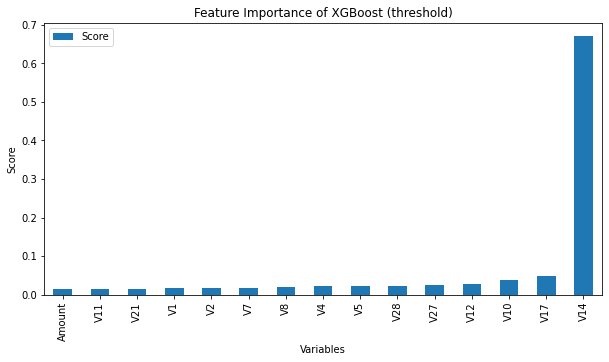

In [51]:
#Store the feature importance of the best model
df_feat = pd.DataFrame(data=xgboost_sm_rfe_hyp.feature_importances_, 
                       index =sel_vars_xgb, columns = ['Score']).sort_values(by='Score')


fig, ax = plt.subplots(figsize=(10,5))

df_feat.plot.bar(ax=ax)
ax.set_xlabel("Variables")
ax.set_ylabel("Score")
ax.set_title("Feature Importance of XGBoost (threshold)")
#df_feat.T.to_csv("C:/Users/Milara/Desktop/New Projects/FraudDetection/xgb_feat_importance_v1.csv", encoding="ISO-8859-1", index= False)

## **Conclusion.**

The current notebook presented a walkthrough example to show model performance using monetary costs and improving the results using a resampling techique to deal with imbalanced datasets for a credit card fraud detection. In addition, other concepts were shown such as feature selection, hyperparameter tunning, overfitting the training data, the scalability of the models and feature importance. Some of the techniques presented in this notebook are based on the Robin Teuwens kernel on Optimizing Fraud Cost [1]. 

## **To Try**

This notebook is only an example of the techniques to use for showing the model results in terms cost and to deal with imbalanced datatest. Nevertheless, there is still more techniques to try, some of the ideas are listed below:

- To apply outlier and correlation removal
- Adding more data (the validation split was not used)
- Expected value as explained in the book [2]
- To use other models
- To use other resampling techniques

## **References.**

+ [1] Robin Teuwens, Precision vs. Recall: Optimizing Fraud Costs, https://www.kaggle.com/robinteuwens/precision-vs-recall-optimizing-fraud-costs?scriptVersionId=19109737
+ [2] Provost,F and Fawcett, Tom. (2013). Data science-what you need to know about analytic-thinking and decision-making. USA: O'RELLY.
+ [3] Janio Bachmann, Credit Fraud || Dealing with Imbalanced Datasets, https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/notebook
+ [4] Kubat,M. (2017) Introduction to Machine Learning. USA: Springer.
+ [5] Unbalanced Datasets & What To Do About Them, https://medium.com/strands-tech-corner/unbalanced-datasets-what-to-do-144e0552d9cd
+ [6] Dealing with Imbalanced Data, https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18
+ [7] How to fix an Unbalanced Dataset, https://www.kdnuggets.com/2019/05/fix-unbalanced-dataset.html
+ [8] 8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset, https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/	
+ [9] Occam's razor, https://en.wikipedia.org/wiki/Occam%27s_razor
+ [10] How to Use ROC Curves and Precision-Recall Curves for Classification in Python, https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ 
+ [11] Plotting Learning Curves, https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
